<a href="https://colab.research.google.com/github/FrederickAlmeida/FashionMNIST-models-comparison/blob/main/ListaPraticaMLPConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LISTA PRÁTICA DAS UNIDADES 1 E 2**

Pode ser feita com o grupo do projeto. Recomendo pair/group programming para que todos vejam um pouco de todas as partes.


Treine e avalie 4 modelos de classificação para a base de dados do FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist,
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).



1.   Um modelo base que não seja uma rede neural, como _decision tree, xgboost, random forest_, etc. Recomendação: use o sklearn (https://scikit-learn.org/).

2.   Uma MLP

3. Uma rede convolucional criada por ti. Recomendação: https://pytorch.org/

4. Use um modelo pré treinado já consolidado na literatura para fazer _transfer learning_. Recomendações: https://pytorch.org/hub/pytorch_vision_vgg/


Compare os resultados dos modelos:
* plote gráficos que mostrem as acurácias de cada modelo
* Indique qual foi a classe na qual o modelo teve pior performance (indique qual métrica usou para concluir isso e faça para cada modelo)
* argumente qual o melhor modelo levando em consideração o tempo de execução e acurácia.

Recomendação use:
https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html .



Recomendação:

Faça um template de treino, validação e teste que funcione para uma API de modelo.

Crie a API para cada modelo que será usado e use o template

# Imports e Downloads

In [24]:
# modelagem e dados
from sklearn.ensemble import RandomForestClassifier

import torch
from torchvision import datasets, transforms
from torch.utils import data

# avaliação
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [26]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor()
])

In [27]:
train_ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=augmentation_transforms
)

test_ds = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=augmentation_transforms
)

In [28]:
length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])

In [29]:
len_train, len_val, len(test_ds)

(51000, 9000, 10000)

In [30]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl = data.DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

In [31]:
instances, targets = next(iter(train_dl))
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

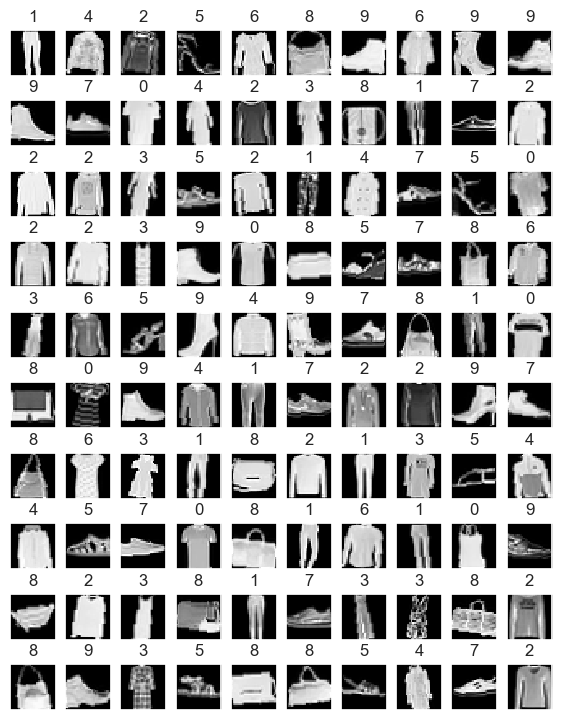

In [32]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = targets[i * w + j].item()
        ax[i][j].set_title(label)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

# Modelo base

# MLP

# Rede Convolucional

# Rede Convolucional consolidada

# Comparação